In [1]:
using Lux, Reactant, Random, Optimisers, Enzyme, Statistics, JLD2, Plots

const cdev = cpu_device()
const xdev = reactant_device(; force=true);

In [2]:
const L = 10.0f0
const t_end = 30.0f0
ν = 0.1f0

const u_mean = 1.0f0
const u_amplitude = 0.5f0
const k = 2.0f0*pi/L
u0(x) = Float32(u_mean + u_amplitude * cos(k*x));

λ_pde = 1.0f0
λ_ic = 0.1f0
λ_bc = 0.1f0;

In [3]:
struct PINN{M} <: AbstractLuxWrapperLayer{:model}
    model::M
end

function PINN(; hidden_dims::Int=64)
    return PINN(
        Chain(
            Dense(2 => hidden_dims, tanh),
            Dense(hidden_dims => hidden_dims, tanh),
            Dense(hidden_dims => hidden_dims, tanh),
            Dense(hidden_dims => hidden_dims, tanh),
            Dense(hidden_dims => 1),
        ),
    )
end;

In [4]:
function u(model::StatefulLuxLayer, xt::AbstractArray)
    return model(xt)
end

function ∂u_∂t(model::StatefulLuxLayer, xt::AbstractArray)
    return Enzyme.gradient(Enzyme.Reverse, sum ∘ model, xt)[1][2, :]
end

function ∂u_∂x(model::StatefulLuxLayer, xt::AbstractArray)
    return Enzyme.gradient(Enzyme.Reverse, sum ∘ model, xt)[1][1, :]
end
function ∂²u_∂x²(model::StatefulLuxLayer, xt::AbstractArray)
    return Enzyme.gradient(Enzyme.Reverse, sum ∘ ∂u_∂x, Enzyme.Const(model), xt)[2][1, :]
end;

In [5]:
function physics_informed_loss_function(model::StatefulLuxLayer, xt::AbstractArray)
    return mean(abs2, ∂u_∂t(model, xt) .+ u(model, xt) .* ∂u_∂x(model, xt) .- (ν .* ∂²u_∂x²(model, xt)))
end
function bc_loss_function(model::StatefulLuxLayer, xt_i::AbstractArray, xt_f::AbstractArray)
    u_i = model(xt_i)
    u_f = model(xt_f)
    mean(abs2, u_i .- u_f)
end
function ic_loss_function(model::StatefulLuxLayer, xt::AbstractArray, target::AbstractArray)
    u = model(xt)
    mean(abs2, u .- target)
end
function loss_function(model, ps, st, (xt, xt_bc_i, xt_bc_f, xt_ic, target_ic))
    smodel = StatefulLuxLayer(model, ps, st)
    physics_loss = physics_informed_loss_function(smodel, xt)
    bc_loss = bc_loss_function(smodel, xt_bc_i, xt_bc_f)
    ic_loss = ic_loss_function(smodel, xt_ic, target_ic)
    loss = λ_pde * physics_loss + λ_bc * bc_loss + λ_ic * ic_loss
    return loss, smodel.st, (; physics_loss, bc_loss, ic_loss, total_loss=loss)
end;

In [6]:
function get_data(rng, batch_size_pde, batch_size_bc, batch_size_ic; current_segment=1, total_segments=10)
    xt = rand(rng, Float32, (2, batch_size_pde))
    xt[1, :] .*= L
    xt[2, :] .*= (t_end/total_segments)
    xt[2, :] .+= (t_end*(current_segment-1)/total_segments)

    rand_t_bc = rand(rng, Float32, batch_size_bc) .* (t_end/total_segments) .+ (t_end*(current_segment-1)/total_segments)
    xt_bc_i = zeros(Float32, (2, batch_size_bc))
    xt_bc_i[2, :] = rand_t_bc

    xt_bc_f = fill(L, (2, batch_size_bc))
    xt_bc_f[2, :] = rand_t_bc
    

    rand_x_ic = rand(rng, Float32, batch_size_ic) .* L
    xt_ic = zeros(Float32, (2, batch_size_ic))
    xt_ic[1, :] = rand_x_ic

    target_ic = reshape(u0.(rand_x_ic), 1, :)
    return (xt, xt_bc_i, xt_bc_f, xt_ic, target_ic)
end;

In [42]:
function train_model(; seed::Int=1, maxiters::Int=10000, hidden_dims::Int=64, 
        batch_size_pde::Int=256, batch_size_bc::Int=64, batch_size_ic::Int=64, total_segments::Int=10)
    
    rng = Random.default_rng()
    Random.seed!(rng, seed)

    pinn = PINN(; hidden_dims)
    ps, st = Lux.setup(rng, pinn) |> xdev

    train_state = Training.TrainState(pinn, ps, st, Adam(0.005f0))

    lr = i -> i < 5000 ? 0.005f0 : (i < 10000 ? 0.0005f0 : 0.00005f0)
    
    total_losses = Float32[]
    physics_losses = Float32[]
    bc_losses = Float32[]
    ic_losses = Float32[]

    for iter in 1:maxiters
        current_segment = ((iter * total_segments) ÷ maxiters) + 1
        
        batch = get_data(rng, batch_size_pde, batch_size_bc, batch_size_ic; current_segment, total_segments) |> xdev
        
        Optimisers.adjust!(train_state, lr(iter))
        
        

        _, loss, stats, train_state = Training.single_train_step!(AutoEnzyme(),
                                                              loss_function,
                                                              batch,
                                                              train_state;
                                                              return_gradients=Val(false),
        )
            
        push!(total_losses, Float32(stats.total_loss))
        push!(physics_losses, Float32(stats.physics_loss))
        push!(bc_losses, Float32(stats.bc_loss))
        push!(ic_losses, Float32(stats.ic_loss))

        if iter % 1000 == 0
            println("Iter: $(iter), loss: $(Float32(loss))")
        end
    end

    return StatefulLuxLayer(pinn, cdev(train_state.parameters), cdev(train_state.states)), (; physics_losses, bc_losses, ic_losses, total_losses)
end;

In [47]:
batch_size_pde = 512
batch_size_bc = 16
batch_size_ic = 16
total_segments = 1
maxiters = 50000
trained_model, losses = train_model(; maxiters, batch_size_pde, batch_size_bc, batch_size_ic, total_segments);

Iter: 1000, loss: 0.0005685659
Iter: 2000, loss: 0.00034723073
Iter: 3000, loss: 0.00047991442
Iter: 4000, loss: 0.00030498373
Iter: 5000, loss: 0.00026955505
Iter: 6000, loss: 0.0002322587
Iter: 7000, loss: 0.00022049231
Iter: 8000, loss: 0.00025490398
Iter: 9000, loss: 0.00023249348
Iter: 10000, loss: 0.00021537968
Iter: 11000, loss: 0.0002201665
Iter: 12000, loss: 0.0002804202
Iter: 13000, loss: 0.00023071222
Iter: 14000, loss: 0.00018665826
Iter: 15000, loss: 0.00019465046
Iter: 16000, loss: 0.0002525913
Iter: 17000, loss: 0.00022340367
Iter: 18000, loss: 0.00023335502
Iter: 19000, loss: 0.00023188248
Iter: 20000, loss: 0.00025624337
Iter: 21000, loss: 0.00018700738
Iter: 22000, loss: 0.00021532355
Iter: 23000, loss: 0.00021570576
Iter: 24000, loss: 0.00023192681
Iter: 25000, loss: 0.00023533791
Iter: 26000, loss: 0.00026521948
Iter: 27000, loss: 0.00020458015
Iter: 28000, loss: 0.00024762828
Iter: 29000, loss: 0.00026367622
Iter: 30000, loss: 0.00019650583
Iter: 31000, loss: 0.000

In [48]:
data=load("burgers1d_periodic.jld2")

t_grid = Float32.(data["times"])
x_grid = Float32.(collect(data["grid"]))
u_target = data["solution"]; 

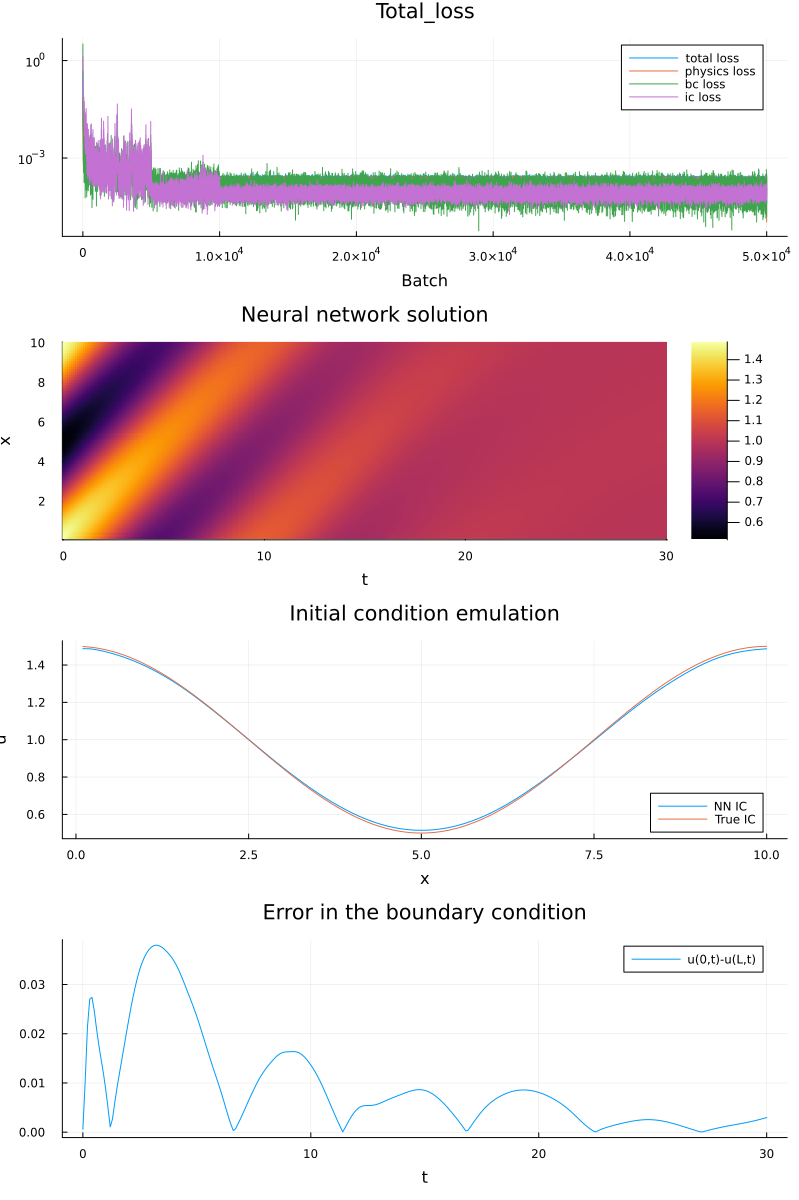

In [49]:
us = zeros(Float32, (length(x_grid), length(t_grid)))
for t_idx in 1:length(t_grid), x_idx in 1:length(x_grid)
    xt = reshape([x_grid[x_idx], t_grid[t_idx]], :, 1)
    us[x_idx, t_idx] = trained_model(xt)[1,1]
end

ic = us[:,1]
bc = abs.(us[1,:] .- us[end,:])

p0 = plot(losses.total_losses, yscale=:log10, xlabel="Batch", ylabel="Loss", title="Total_loss", label="total loss")
plot!(p0, losses.physics_losses, label="physics loss")
plot!(p0, losses.bc_losses, label="bc loss")
plot!(p0, losses.ic_losses, label="ic loss")
p1 = heatmap(t_grid, x_grid, us, xlabel="t", ylabel='x', title="Neural network solution")
p2 = plot(x_grid, ic, xlabel="x", ylabel="u", label="NN IC")
plot!(p2, x_grid, u0.(x_grid), label="True IC", title="Initial condition emulation")
p3 = plot(t_grid, bc, xlabel="t", ylabel="Δu", label="u(0,t)-u(L,t)", title="Error in the boundary condition")
plt = plot(p0, p1, p2, p3, layout=(4,1), size=(800,1200))
#savefig(plt, "curriculum_with_ic.png");

[ Info: Saved animation to /home/mlenes/Code/surrogate_flow/emulated_burgers.gif


Plots.AnimatedGif("/home/mlenes/Code/surrogate_flow/emulated_burgers.gif")
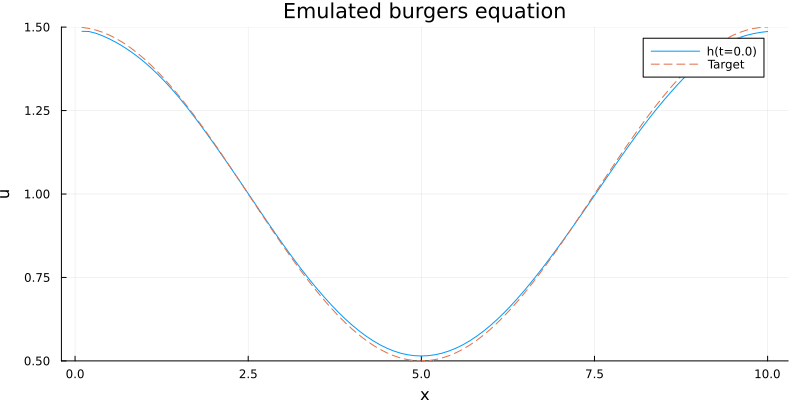

In [50]:
anim = @animate for i in 1:length(t_grid)
    p1 = plot(x_grid, us[:,i], label="h(t=$(round(t_grid[i],digits=2)))", xlabel='x', ylabel='u', ylim=(u_mean-u_amplitude, u_mean+u_amplitude))
    plot!(x_grid, u_target[i], label="Target", linestyle=:dash, legend=:topright)
    plot(p1, size=(800,400), title="Emulated burgers equation")
end
gif(anim, "emulated_burgers.gif", fps=15)